## Plotting Goals: Nice Maps
##### load modules:

In [2]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.colors as colors
from matplotlib import style
import cartopy.feature as cfeature

import util

### Import Epoch Data

In [3]:
ds_djf_epoch = xr.open_zarr('data/cesm-le-fields-djf-epoch-mean-recent.zarr')

### Run a quick set of plots to make sure everything is there:

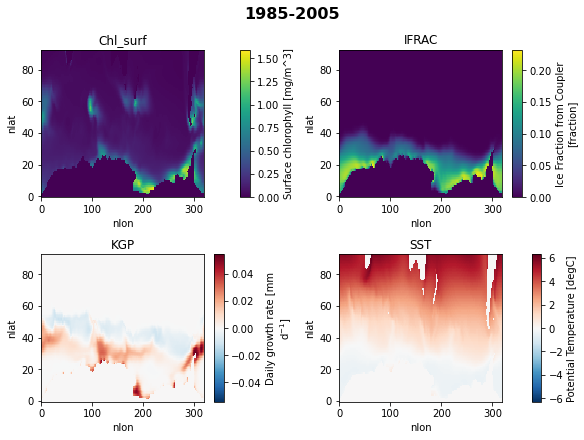

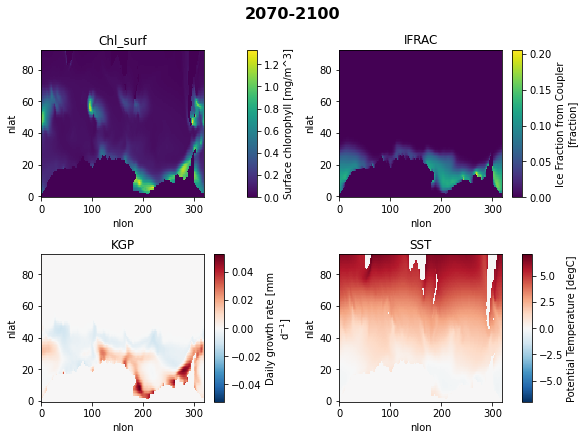

In [4]:
for epoch in ds_djf_epoch.epoch.values:

    nvar = len(ds_djf_epoch.data_vars)
    ncol = int(np.sqrt(nvar))
    nrow = int(nvar/ncol) + min(1, nvar%ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow),
                           constrained_layout=True)

    for i, v in enumerate(ds_djf_epoch.data_vars):
        plt.axes(ax.ravel()[i])

        with xr.set_options(keep_attrs=True):             
            var = ds_djf_epoch[v].sel(epoch=epoch).mean('member_id')
        if 'length' in var.dims:
            var = var.sel(length=40.)            
        var.plot()
        plt.title(v);
    plt.suptitle(epoch, fontsize=16, fontweight='bold');

Find the high and low data

In [83]:
#ds_test = ds_djf_epoch['KGP'].sel(epoch='1985-2005').sel(length = '40').where(ds_djf_epoch.KMT >0)
#ds_test = ds_djf_epoch['KGP'].sel(epoch='2070-2100').sel(length = '40').where(ds_djf_epoch.KMT >0)

#ds_test = ds_djf_epoch['SST'].sel(epoch='2070-2100').where(ds_djf_epoch.KMT >0)
#ds_test = ds_djf_epoch['SST'].sel(epoch='1985-2005').where(ds_djf_epoch.KMT >0)

ds_test = ds_djf_epoch['Chl_surf'].sel(epoch='1985-2005').where(ds_djf_epoch.KMT >0)
#ds_test = ds_djf_epoch['Chl_surf'].sel(epoch='2070-2100').where(ds_djf_epoch.KMT >0)


#ds_test

In [84]:
member_id_pick = [
    ds_test.where(ds_test == ds_test.max(),
                     drop=True).member_id.values.astype('int')[0],
    ds_test.where(ds_test == ds_test.min(),
                     drop=True).member_id.values.astype('int')[0]
]

In [85]:
forced = ds_test.mean('member_id').compute()
internal = [(ds_test.sel(member_id=i) - forced).compute()
            for i in member_id_pick]

forced

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'Chl_surf' (nlat: 93, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.64179644, 0.63597025, 0.62685005, ...,        nan,        nan,
               nan],
       ...,
       [0.0237806 , 0.02322329, 0.02271316, ..., 0.02541019, 0.02488319,
        0.02433395],
       [0.02387736, 0.02327733, 0.02268204, ..., 0.02549478, 0.02499994,
        0.0244539 ],
       [0.02389735, 0.02324296, 0.02257131, ..., 0.02552421, 0.02505969,
        0.02451154]])
Coordinates:
    KMT      (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    epoch    <U9 '1985-2005'
Dimensions without coordinates: nlat, nlon

## Plot internal vs Forced
Compute the forced (ensemble mean) and internal components. Call compute on these dataset to trigger loading into memory so that subsequent plotting operations proceed as rapidly as possible.



In [47]:
## Create Datafields to plot
kgp_mean = ds_djf_epoch['KGP'].where(ds_djf_epoch.KMT > 0).mean('member_id')
sst_mean = ds_djf_epoch['SST'].where(ds_djf_epoch.KMT > 0).mean('member_id')
chl_mean = ds_djf_epoch['Chl_surf'].where(ds_djf_epoch.KMT > 0).mean('member_id')
ice_mean = ds_djf_epoch['IFRAC'].where(ds_djf_epoch.KMT > 0).mean('member_id')

kgp_early = kgp_mean.sel(length='40').sel(epoch='1985-2005')
kgp_late = kgp_mean.sel(length='40').sel(epoch='2070-2100')

sst_early = sst_mean.sel(epoch='1985-2005')
sst_late = sst_mean.sel(epoch='2070-2100')
chl_early = chl_mean.sel(epoch='1985-2005')
chl_late = chl_mean.sel(epoch='2070-2100')
ice_early = ice_mean.sel(epoch='1985-2005')
ice_late = ice_mean.sel(epoch='2070-2100')

# Lat Lon Checks
lon = ds_djf_epoch.TLONG.values
lat = ds_djf_epoch.TLAT.values

internal = member 28 and 26

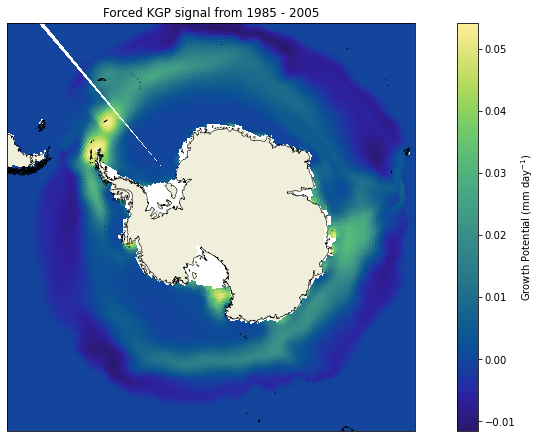

In [48]:
fig = plt.figure(figsize=(15,7.5))
#fig.suptitle('Seasonal DJF Krill Production from 1985 - 2005')#, fontsize=)
#cmap = 'nipy_spectral'
#cmap = new_cmap
cmap= cmocean.cm.curl
#----------Chl
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Forced KGP signal from 1985 - 2005')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, forced.where(forced.KMT >0), cmap=cmap,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Growth Potential (mm day$^{-1}$)')
#fig.savefig('Seasonal DJF Climatologies from 30 year epochs CESM-LE: 1985-2005', bbox_inches='tight') #,format='pdf');


In [49]:
#Plot SST
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


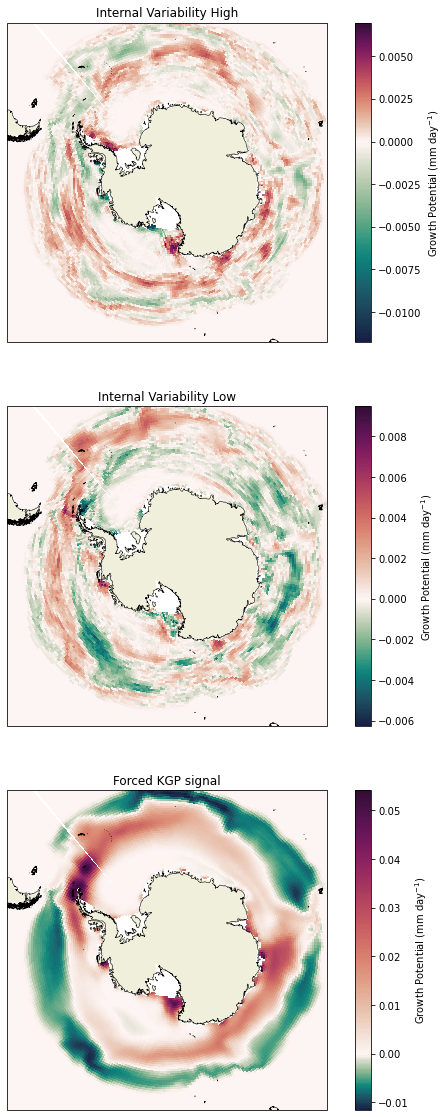

In [62]:
fig = plt.figure(figsize=(10, 20))
fig.suptitle('1985 - 2005')#, fontsize=)
#cmap = 'nipy_spectral'
#cmap = new_cmap
cmap= cmocean.cm.curl

#----------Chl
ax = fig.add_subplot(312, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability Low')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[0], cmap=cmap, norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Growth Potential (mm day$^{-1}$)')

ax = fig.add_subplot(311, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability High')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[1], cmap=cmap, norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Growth Potential (mm day$^{-1}$)')

ax = fig.add_subplot(313, projection=ccrs.SouthPolarStereo())
ax.set_title('Forced KGP signal')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, forced, cmap=cmap, norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Growth Potential (mm day$^{-1}$)')
plt.savefig('data/1985-2005 Mean Internal vs Forced.png')

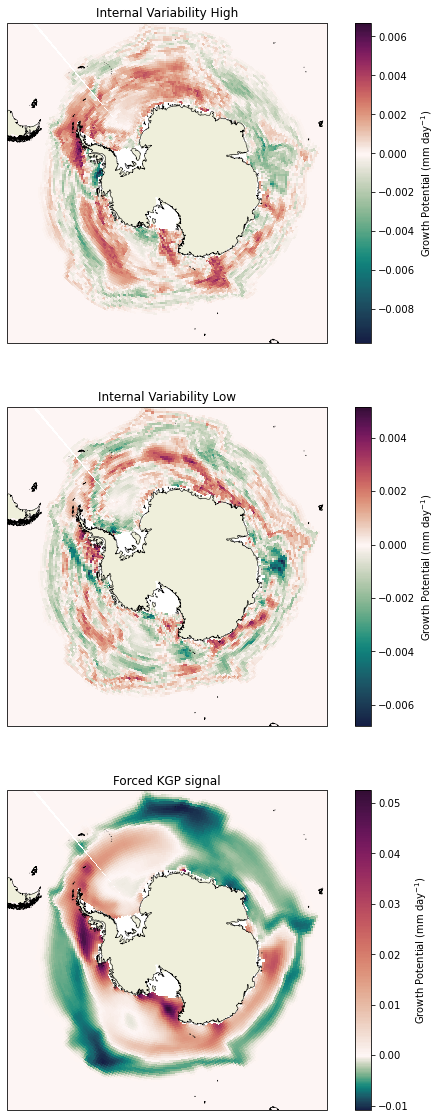

In [67]:
fig = plt.figure(figsize=(10, 20))
#fig.suptitle('1985 - 2005')#, fontsize=)
#cmap = 'nipy_spectral'
#cmap = new_cmap
cmap= cmocean.cm.curl

#----------Chl
ax = fig.add_subplot(312, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability Low')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[0], cmap=cmap, norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Growth Potential (mm day$^{-1}$)')

ax = fig.add_subplot(311, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability High')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[1], cmap=cmap, norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Growth Potential (mm day$^{-1}$)')

ax = fig.add_subplot(313, projection=ccrs.SouthPolarStereo())
ax.set_title('Forced KGP signal')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, forced, cmap=cmap, norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Growth Potential (mm day$^{-1}$)')
plt.savefig('data/1985-2005 Mean Internal vs Forced.png')

In [118]:
#Plot SST
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

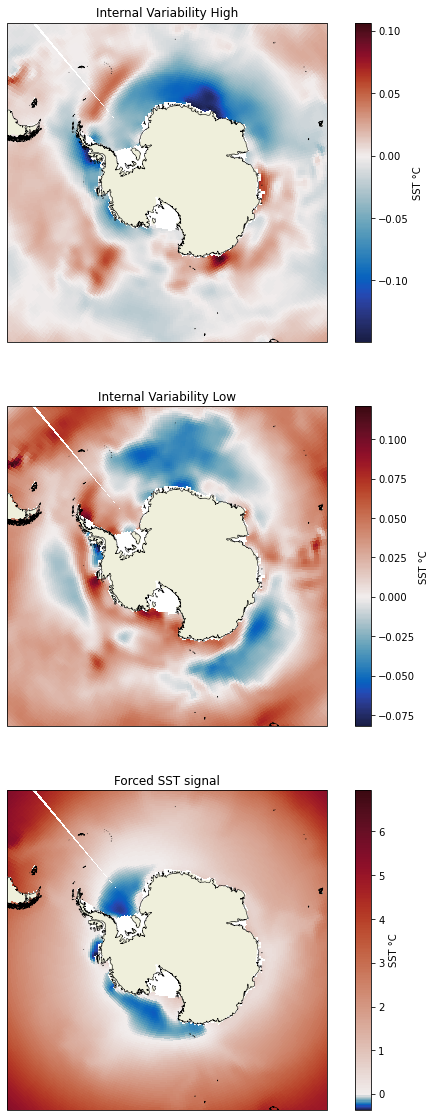

In [78]:

#fig.savefig('Seasonal DJF Climatologies from 30 year epochs CESM-LE: 1985-2005', bbox_inches='tight') #,format='pdf');
fig = plt.figure(figsize=(10, 20))
#fig.suptitle('1985 - 2005')#, fontsize=)
#cmap = 'nipy_spectral'
#cmap = new_cmap
cmap= cmocean.cm.balance

#----------Chl
ax = fig.add_subplot(312, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability Low')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[0], cmap=cmap, 
                 norm=MidpointNormalize(midpoint=0.), #vmin = -1,vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')

ax = fig.add_subplot(311, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability High')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[1], cmap=cmap, 
                 norm=MidpointNormalize(midpoint=0.), #vmin = -1,vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')

ax = fig.add_subplot(313, projection=ccrs.SouthPolarStereo())
ax.set_title('Forced SST signal')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, forced, cmap=cmap,                 
                 norm=MidpointNormalize(midpoint=0.), #vmin = -1,vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='SST °C')
plt.savefig('data/2070-2100 Mean Internal vs Forced SST.png')

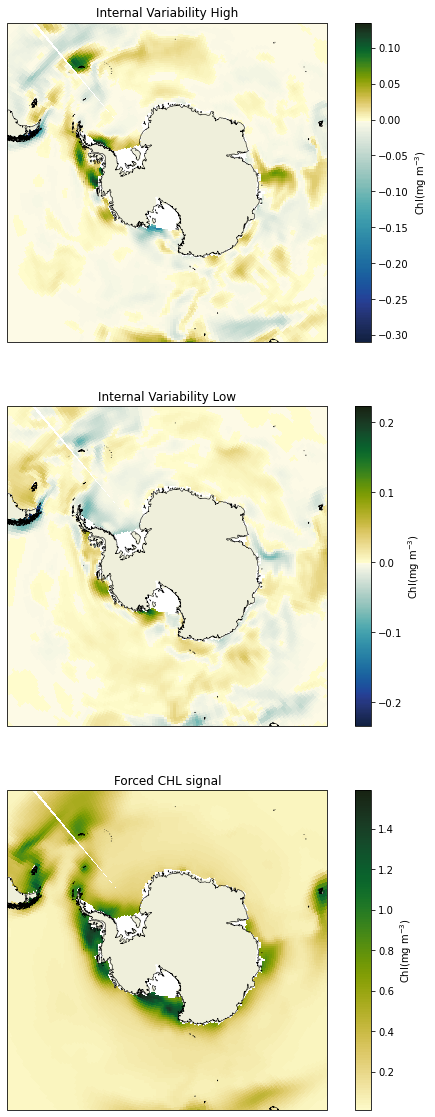

In [86]:

fig = plt.figure(figsize=(10, 20))

cmap= cmocean.cm.delta

#----------Chl
ax = fig.add_subplot(312, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability Low')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[0], cmap=cmap, 
                 norm=MidpointNormalize(midpoint=0.), #vmin = -1,vmax = 6,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Chl(mg m$^{-3}$)')

ax = fig.add_subplot(311, projection=ccrs.SouthPolarStereo())
ax.set_title('Internal Variability High')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, internal[1], cmap=cmap, 
                 norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Chl(mg m$^{-3}$)')

ax = fig.add_subplot(313, projection=ccrs.SouthPolarStereo())
ax.set_title('Forced CHL signal')
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.add_feature(cfeature.LAND)

pc=ax.pcolormesh(lon, lat, forced, cmap=cmap,                 
                 norm=MidpointNormalize(midpoint=0.),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,label='Chl(mg m$^{-3}$)')
plt.savefig('data/1985-2005 Mean Internal vs Forced CHL.png')